In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=be27b601b76d018c8c75ec26b67e1ac8c41392bdd4ff74e6fbc5f3e37fe12491
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Geral

In [4]:
lyrics = spark.read.csv("/content/drive/MyDrive/TCC/KledysonHenrique/Datasets/lyrics.csv",
                       escape="\"",
                       sep=',',
                       header=True,
                       inferSchema=True,
                       encoding="utf-8")

In [5]:
lyrics.printSchema()

root
 |-- Artist: string (nullable = true)
 |-- Album: string (nullable = true)
 |-- Track: string (nullable = true)
 |-- Lyrics: string (nullable = true)



In [6]:
lyrics.show()

+--------------------+--------------------+--------------------+--------------------+
|              Artist|               Album|               Track|              Lyrics|
+--------------------+--------------------+--------------------+--------------------+
|      Throwing bones| these clothes ai...|               bitch|they need to keep...|
|  It's the Crackhead|  rolling up napkins| have to talk all...|I'm a beast thoug...|
|Standing On The C...|           Red Burns|!Can I Kick It? w...|!Can I Kick It? w...|
|          Charli XCX|                  14|     !Franchesckaar!|!Franchesckaar! [...|
|          Charli XCX|     !Franchesckaar!|     !Franchesckaar!|!Franchesckaar! [...|
|               Wstrn|          DOU3LE 3AK|                  #1|# You know better...|
|       Kelly Rowland|Talk a Good Game ...|                  #1|# [ ] I promise t...|
|   Animal Collective|      Strawberry Jam|                  #1|# Noah: Mine, I w...|
|     Imagine Dragons|Mercury - Acts 1 & 2|           

In [7]:
num_rows = lyrics.count()
print("Número de linhas do DataFrame 'lyrics':", num_rows)

Número de linhas do DataFrame 'lyrics': 200053


## Analisando Bases

In [ ]:
# lyrics_english = lyrics.filter(lyrics["Language"] == "English").groupBy("Language").count()

In [ ]:
# lyrics_english.limit(5).show()

### Word Cloud | Nuvem de Palavras

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
amostra = lyrics.select('Lyrics').sample(fraction=0.1, seed=101)
tudo = [lyrics['Lyrics'] for lyrics in amostra.collect()]

In [14]:
wordcloud = WordCloud(collocations=False, prefer_horizontal=1, background_color='white', width=1000, height=600).generate(str(tudo))

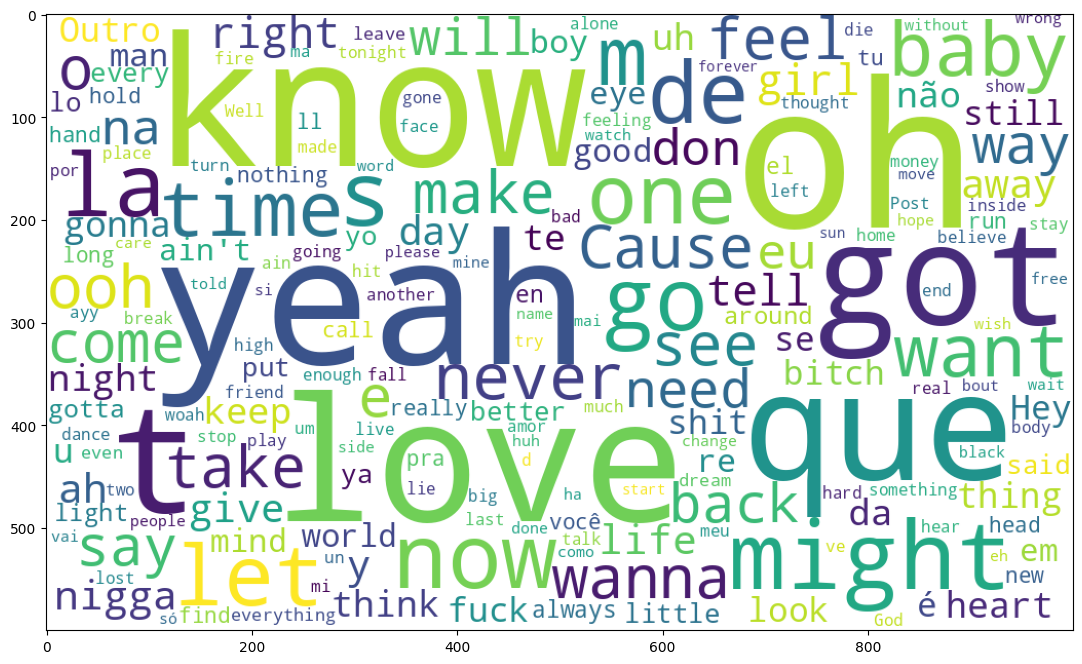

In [15]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.show()

Um dos problemas evidentes é que as lyrics do genius utilizam muitas tags para separar o corpo das Lyrics

## Limpeza dos caracteres especiais

In [16]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
import pyspark.sql.functions as f

In [18]:
lyrics = lyrics.withColumn("lyrics_regex", f.regexp_replace("Lyrics", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [19]:
lyrics.limit(2).show(truncate=False)

+------------------+----------------------------+-------------------------+---------------------------------+------------------------------+
|Artist            |Album                       |Track                    |Lyrics                           |lyrics_regex                  |
+------------------+----------------------------+-------------------------+---------------------------------+------------------------------+
|Throwing bones    | these clothes ain't glowing| bitch                   |they need to keep you froze      |they need to keep you froze   |
|It's the Crackhead| rolling up napkins         | have to talk all my shit|I'm a beast though (Beast though)|Im a beast though Beast though|
+------------------+----------------------------+-------------------------+---------------------------------+------------------------------+



In [21]:
lyrics = lyrics.withColumn("lyrics_limpo", f.trim(lyrics.lyrics_regex))
lyrics.limit(2).show()

+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            Artist|               Album|               Track|              Lyrics|        lyrics_regex|        lyrics_limpo|
+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    Throwing bones| these clothes ai...|               bitch|they need to keep...|they need to keep...|they need to keep...|
|It's the Crackhead|  rolling up napkins| have to talk all...|I'm a beast thoug...|Im a beast though...|Im a beast though...|
+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [22]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="lyrics_limpo", outputCol="tokens")
tokenizado = tokenizer.transform(lyrics)

In [23]:
tokenizado.select("lyrics_limpo", "tokens").show()

+--------------------+--------------------+
|        lyrics_limpo|              tokens|
+--------------------+--------------------+
|they need to keep...|[they, need, to, ...|
|Im a beast though...|[im, a, beast, th...|
|Can I Kick It wit...|[can, i, kick, it...|
|Franchesckaar [] ...|[franchesckaar, [...|
|Franchesckaar [] ...|[franchesckaar, [...|
|You know better y...|[you, know, bette...|
|[ ] I promise tha...|[[, ], i, promise...|
|Noah Mine I want ...|[noah, mine, i, w...|
|TranslationsРусск...|[translationsрусс...|
|TranslationsРусск...|[translationsрусс...|
|[ ] I promise tha...|[[, ], i, promise...|
|TranslationsРусск...|[translationsрусс...|
|Chance Pirate TV ...|[chance, pirate, ...|
|Fan [] Well aye a...|[fan, [], well, a...|
|Fan [] Well aye a...|[fan, [], well, a...|
|Fan [] Well aye a...|[fan, [], well, a...|
|Hit Song On the b...|[hit, song, on, t...|
|Stunna [ YUNG MUT...|[stunna, [, yung,...|
|Stunna [ Baby] Fo...|[stunna, [, baby]...|
|Zero [ ] Listen n...|[zero, [, 

In [24]:
from pyspark.sql.types import IntegerType
# Entendendo em quantos tokens os comentários foram divididos
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("lyrics_limpo", "tokens").withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|        lyrics_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|they need to keep...|[they, need, to, ...|          6|
|Im a beast though...|[im, a, beast, th...|          6|
|Can I Kick It wit...|[can, i, kick, it...|         43|
|Franchesckaar [] ...|[franchesckaar, [...|        453|
|Franchesckaar [] ...|[franchesckaar, [...|        453|
|You know better y...|[you, know, bette...|        401|
|[ ] I promise tha...|[[, ], i, promise...|        464|
|Noah Mine I want ...|[noah, mine, i, w...|        118|
|TranslationsРусск...|[translationsрусс...|        412|
|TranslationsРусск...|[translationsрусс...|        412|
|[ ] I promise tha...|[[, ], i, promise...|        464|
|TranslationsРусск...|[translationsрусс...|        412|
|Chance Pirate TV ...|[chance, pirate, ...|        164|
|Fan [] Well aye a...|[fan, [], well, a...|        289|
|Fan [] Well aye a...|[fan, [], well, a...|     

## StopWords

In [25]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
from pyspark.ml.feature import StopWordsRemover

In [28]:
stop_B = StopWordsRemover.loadDefaultStopWords("english")

In [31]:
stop_C = stopwords.words("portuguese")
stop_D = StopWordsRemover.loadDefaultStopWords("portuguese")

Juntando em um stop só

In [32]:
stop_full = stop_A + stop_B + stop_C + stop_D

In [ ]:
stop_full

In [33]:
remover = StopWordsRemover(inputCol="tokens", outputCol="lyrics_final", stopWords=stop_full)
feature_lyrics = remover.transform(tokenizado)

In [34]:
feature_lyrics.limit(11).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|              Artist|               Album|               Track|              Lyrics|        lyrics_regex|        lyrics_limpo|              tokens|        lyrics_final|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Throwing bones| these clothes ai...|               bitch|they need to keep...|they need to keep...|they need to keep...|[they, need, to, ...| [need, keep, froze]|
|  It's the Crackhead|  rolling up napkins| have to talk all...|I'm a beast thoug...|Im a beast though...|Im a beast though...|[im, a, beast, th...|[im, beast, thoug...|
|Standing On The C...|           Red Burns|!Can I Kick It? w...|!Can I Kick It? w...|Can I Kick It wit...|Can I Kick It wit...|[can, i, kick, it...|[k

In [35]:
feature_lyrics.select("tokens", "lyrics_final")\
    .withColumn("Frq_tokens", countTokens(f.col("tokens")))\
    .withColumn("Freq_tokens_limpos", countTokens(f.col("lyrics_final"))).show()

+--------------------+--------------------+----------+------------------+
|              tokens|        lyrics_final|Frq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+----------+------------------+
|[they, need, to, ...| [need, keep, froze]|         6|                 3|
|[im, a, beast, th...|[im, beast, thoug...|         6|                 5|
|[can, i, kick, it...|[kick, wit, ah, a...|        43|                18|
|[franchesckaar, [...|[franchesckaar, [...|       453|               254|
|[franchesckaar, [...|[franchesckaar, [...|       453|               254|
|[you, know, bette...|[know, better, kn...|       401|               210|
|[[, ], i, promise...|[[, ], promise, w...|       464|               221|
|[noah, mine, i, w...|[noah, mine, want...|       118|                66|
|[translationsрусс...|[translationsрусс...|       412|               221|
|[translationsрусс...|[translationsрусс...|       412|               221|
|[[, ], i, promise...|[[, ], promise, 

## Bag of words

In [36]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="lyrics_final", outputCol="CountVec")
model = cv.fit(feature_lyrics)
CountVectorizer_features = model.transform(feature_lyrics)

CountVectorizer_features.select('lyrics_final', 'CountVec').limit(5).show()

+--------------------+--------------------+
|        lyrics_final|            CountVec|
+--------------------+--------------------+
| [need, keep, froze]|(262144,[35,46,38...|
|[im, beast, thoug...|(262144,[0,297,16...|
|[kick, wit, ah, a...|(262144,[1,10,13,...|
|[franchesckaar, [...|(262144,[2,3,4,6,...|
|[franchesckaar, [...|(262144,[2,3,4,6,...|
+--------------------+--------------------+



## Hashing TF

Reduzir poder computacional necessário já que se trata de uma grande base de dados

In [37]:
from pyspark.ml.feature import HashingTF

HashingTF = HashingTF(inputCol="lyrics_final", outputCol="hashingTF")
HashingTF.setNumFeatures(50)

HTFfeaturizedData = HashingTF.transform(CountVectorizer_features)

In [38]:
HTFfeaturizedData.select("lyrics_final", "HashingTF").limit(5).show()

+--------------------+--------------------+
|        lyrics_final|           HashingTF|
+--------------------+--------------------+
| [need, keep, froze]|(50,[3,37,44],[1....|
|[im, beast, thoug...|(50,[0,23,35],[2....|
|[kick, wit, ah, a...|(50,[6,15,24,25,2...|
|[franchesckaar, [...|(50,[0,1,2,3,4,5,...|
|[franchesckaar, [...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



TF-IDF: estabelecendo pesos

In [39]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [40]:
TFIDFfeaturizedData.select("lyrics_final", "features").limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
HTFfeaturizedData.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|              Artist|               Album|               Track|              Lyrics|        lyrics_regex|        lyrics_limpo|              tokens|        lyrics_final|            CountVec|           hashingTF|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Throwing bones| these clothes ai...|               bitch|they need to keep...|they need to keep...|they need to keep...|[they, need, to, ...| [need, keep, froze]|(262144,[35,46,38...|(50,[3,37,44],[1....|
|  It's the Crackhead|  rolling up napkins| have to talk all...|I'm a beast thoug...|Im a beast though...|Im a beast though...|[im, a, beast, th...|[im,

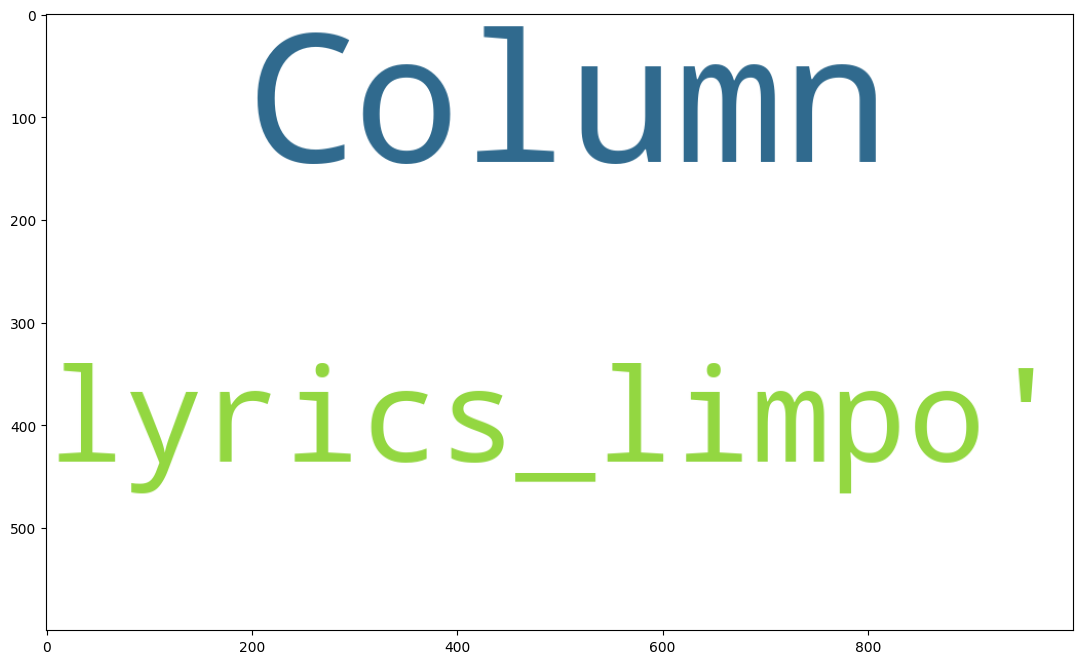

In [46]:
amostra = HTFfeaturizedData.select('lyrics_limpo').sample(fraction=0.1, seed=101)
tudo = [HTFfeaturizedData['lyrics_limpo'] for lyrics in amostra.collect()]
wordcloud = WordCloud(collocations=False, prefer_horizontal=1, background_color='white', width=1000, height=600).generate(str(tudo))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.show()